Here we follow the third PyEmma tutorial: http://www.emma-project.org/latest/tutorials/notebooks/03-msm-estimation-and-validation.html#Case-2:-low-dimensional-molecular-dynamics-data-(alanine-dipeptide)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import deeptime
import pyemma

## Case 1: Toy Model

From the tutorial:

> We load the two-dimensional trajectory from an archive using numpy and directly discretize the full space using k-means clustering:

In this case, we're going to use the deeptime K-means clustering algorithm: https://deeptime-ml.github.io/latest/notebooks/clustering.html#K-means

We note that there are two types of K-means clustering initialization, and we take a look at both of them.

In [2]:
from tqdm.notebook import tqdm
from deeptime.clustering import KMeans

file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = fh['trajectory']

### Clustering with uniform initialization

In [3]:
estimator = KMeans(
    n_clusters=50,  # place 50 cluster centers
    init_strategy='uniform',  # uniform initialization strategy
    max_iter=0,  # don't actually perform the optimization, just place centers
    fixed_seed=13,
    n_jobs=8,
    progress=tqdm
)

clustering = estimator.fit(data).fetch_model()
assignments = clustering.transform(data)

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

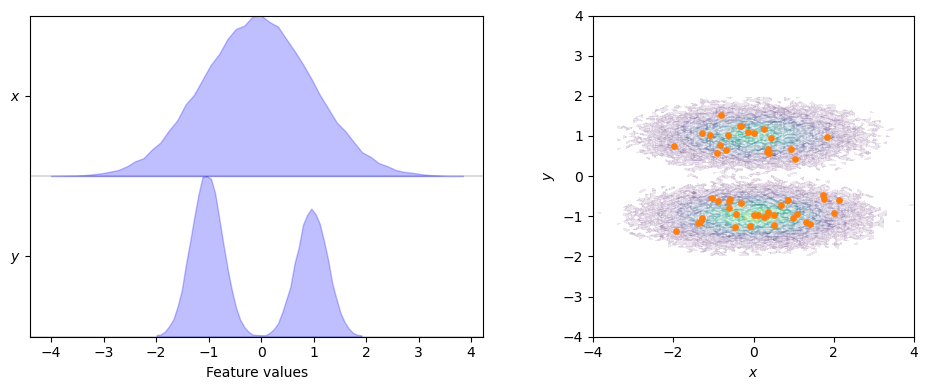

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(data, feature_labels=['$x$', '$y$'], ax=axes[0])
pyemma.plots.plot_density(*data.T, ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(*(clustering.cluster_centers.T), s=15, c='C1')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
fig.tight_layout()

### Clustering with k-means++

In [5]:
estimator = KMeans(
    n_clusters=50,  # place 50 cluster centers
    init_strategy='kmeans++',  # kmeans++ initialization strategy
    max_iter=0,  # don't actually perform the optimization, just place centers
    fixed_seed=13,
    n_jobs=8,
    progress=tqdm
)

clustering = estimator.fit(data).fetch_model()
assignments = clustering.transform(data)

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

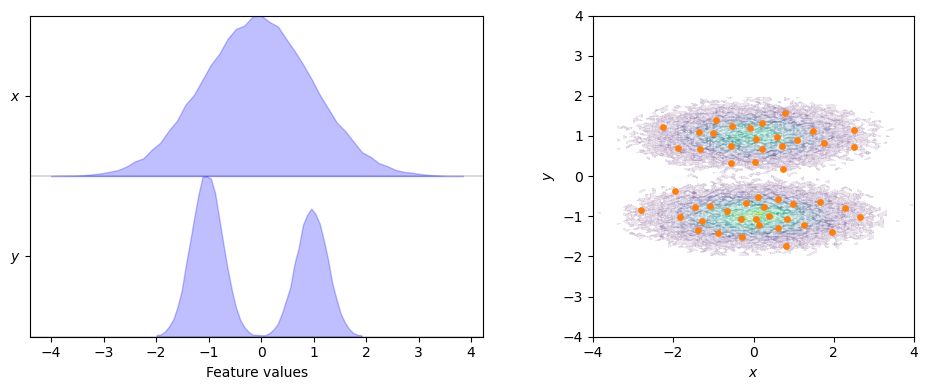

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(data, feature_labels=['$x$', '$y$'], ax=axes[0])
pyemma.plots.plot_density(*data.T, ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(*(clustering.cluster_centers.T), s=15, c='C1')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
fig.tight_layout()

The second is closer to what the PyEmma function seems to do by default (even if it takes a little longer.)  Be aware!

From the PyEmma tutorial:
> The first step after obtaining the discretized dynamics is finding a suitable lag time. The systematic approach is to estimate MSMs at various lag times and observe how the implied timescales (ITSs) of these models behave. In particular, we are looking for lag time ranges in which the implied timescales are constant (i.e., lag time independent as described in the manuscript in Section 2.1). To this aim, PyEMMA provides the its() function which we use to track the first three (nits=3) implied timescales

There are similar helper functions in deeptime; however, first we need to talk about what an "implied timescale" is.

Recall (or see "An Introduction to Markov State Models and Their Application to Long Timescale Molecular Simulation" or the deeptime documentation on MSMs) that a Markov State Model means finding a model of a process over a set of states, which we assume to be discrete (that's why we did clustering in the last step!).  The Markov state model is associated with a set of probabilities, $P{ij} = P(X_{t+1}=j | X_t = i)$ that are collected in a transition state matrix, and this depends on the lag time, because the way you build the transition matrix is by counting transitions (see https://deeptime-ml.github.io/latest/notebooks/transition-counting.html) which is to say if you are at a state $i$ at one time $t$, what state are you in at a time $t+\tau$, where $\tau$ is the lag time?

The "implied timescale" is another word for the relaxation times of different processes captured by the transition matrix, which are related to the eigenvalues of the matrix as

$$
t_i = -\frac{\tau}{\ln \lambda_i}
$$

Recall that for such a matrix, the largest eigenvalue will always be 1, which gives a $t_1 = \infty$ corresponding to the equilibrium distribution (which never changes or decays).

We usually assume that a model is ``good'' or *valid* if it passes the Chapman-Kolmogorov test / satisfies the Chapman-Kolmogorov equation:

$$
T(n\tau) = T(\tau)^n
$$

This is a formal way of saying that if you take $n$ steps using a model with a lag time of $\tau$, it should be equivalent to taking one step using a model with a lag time of $n\tau$.  

What if this is *not* the case?  What if you get different results from these two different models? You probably haven't fully resolved your process and your assumption that the process is *Markovian* could be violated, so it is *very* important to check implied timescales *and* perform a Chapman-Kolmogorov test to validate your final model.

In [10]:
from deeptime.plots import plot_implied_timescales

Text(0, 0.5, 'timescale (steps)')

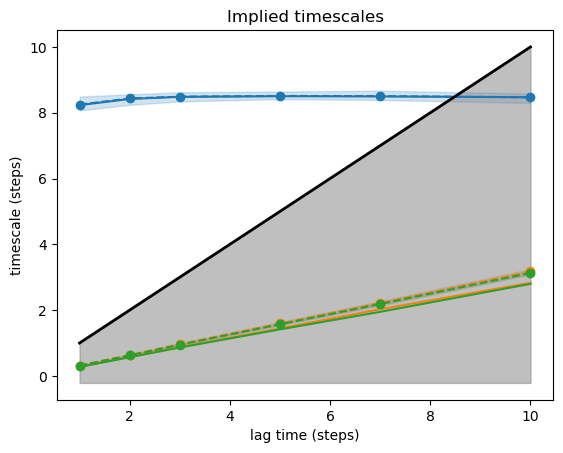

In [24]:
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales

models = []
lagtimes = [1, 2, 3, 5, 7, 10]
for lagtime in lagtimes:
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(assignments)
    models.append(BayesianMSM(n_samples=50).fit_fetch(counts))

its_data = implied_timescales(models)

fig, ax = plt.subplots(1, 1)
plot_implied_timescales(its_data, n_its=3, ax=ax)

ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')

From the PyEmma tutorial:
> The above plot tells us that there is one resolved process with an ITS of approximately 8.5 steps (blue) which is largely invariant to the MSM lag time. The other two ITSs (green, red) are smaller than the lag time (black line, grey-shaded area); they correspond to processes which are faster than the lag time and, thus, are not resolved. Since the implied timescales are, like the corresponding eigenvalues, sorted in decreasing order, we know that all other remaining processes must be even faster.
> 
> As MSMs tend to underestimate the true ITSs, we are looking for a converged maximum in the ITS plot. In our case, any lag time before the slow process (blue line) crosses the lag time threshold (black line) would work. To maximize the kinetic resolution, we choose the lag time 1 step.
> 
> To see whether our model satisfies Markovianity, we perform (and visualize) a Chapman-Kolmogorow (CK) test. Since we aim at modeling the dynamics between metastable states rather than between microstates, this will be conducted in the space of metastable states. The latter are identified automatically using PCCA++ (which is explained in Notebook 05 📓). We usually choose the number of metastable states according to the implied timescales plot by identifying a gap between the ITS. For a single process, we can assume that there are two metastable states between which the process occurs.

to do a CK test with deeptime, we'll need: https://deeptime-ml.github.io/latest/api/generated/deeptime.util.validation.ck_test.html#deeptime.util.validation.ck_test

note also the discussion of how to do PCCA++: https://deeptime-ml.github.io/latest/notebooks/pcca.html